In [60]:
# app.ipynb

# --- 1. Import libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error
# Optional for residual correction later:
# from sklearn.linear_model import HuberRegressor

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True


In [61]:
# If your CSV is elsewhere, change the path
CSV_PATH = "activities.csv"
df_raw = pd.read_csv(CSV_PATH)
df_raw.head()


,Activity ID,Activity Date,Activity Name,Activity Type,Activity Description,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Commute,...,Intensity,Average Grade Adjusted Pace,Timer Time,Total Cycles,Recovery,With Pet,Competition,Long Run,For a Cause,Media
0,10804715041,"21 Feb 2024, 01:17:32",Nike Run Club: 30 Minute Head Starts,Run,NaN,1800,3.39,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10817747904,"23 Feb 2024, 01:18:06",Nike Run Club: Sneaky Speed,Run,NaN,1855,0.06,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10823773204,"24 Feb 2024, 02:01:25",Night Run,Run,NaN,1885,2.68,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10829706530,"24 Feb 2024, 21:11:50",Nike Run Club: Another 10K Run,Run,NaN,320,0.23,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10837129218,"25 Feb 2024, 20:23:26",Afternoon Run,Run,NaN,1778,4.68,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
def fmt_time(sec: float) -> str:
    """Convert seconds to M:SS string."""
    sec = float(sec)
    m = int(sec // 60)
    s = int(round(sec - 60*m))
    if s == 60:
        m, s = m + 1, 0
    return f"{m}:{s:02d}"

def clean_runs(df: pd.DataFrame) -> pd.DataFrame:
    """
    Keep sensible RUN activities and prefer Moving Time over Elapsed Time.
    Applies:
      - choose time column (Moving Time if available)
      - numeric coercion
      - positive values
      - 2–25 km
      - <4 hours
      - pause filter if both times exist (Elapsed/Moving < 1.05)
    """
    df = df.copy()

    # Activity type (fallback to assuming runs if missing)
    if "Activity Type" in df.columns:
        df = df[df["Activity Type"] == "Run"].copy()

    # Time column preference
    time_col = "Moving Time" if "Moving Time" in df.columns else "Elapsed Time"
    if time_col not in df.columns:
        raise ValueError("Neither 'Moving Time' nor 'Elapsed Time' found in CSV.")

    # Coerce numeric
    df["TimeSec"]  = pd.to_numeric(df[time_col], errors="coerce")
    if "Distance" not in df.columns:
        raise ValueError("Column 'Distance' (km) not found in CSV.")
    df["Distance"] = pd.to_numeric(df["Distance"], errors="coerce")

    # Drop invalid
    df = df.dropna(subset=["TimeSec", "Distance"])
    df = df[(df["TimeSec"] > 0) & (df["Distance"] > 0)]

    # Practical bounds
    df = df[(df["Distance"] >= 2.0) & (df["Distance"] <= 25.0)]
    df = df[df["TimeSec"] <= 4 * 3600]

    # Stricter pause filter if both times exist
    if {"Elapsed Time", "Moving Time"}.issubset(df.columns):
        et = pd.to_numeric(df["Elapsed Time"], errors="coerce")
        mt = pd.to_numeric(df["Moving Time"], errors="coerce")
        pause_ratio = et / mt
        df = df[pause_ratio < 1.05]  # <=5% paused time

    return df


def fit_personal_curve(df: pd.DataFrame):
    """
    Fit T = c * D^k via log–log linear regression, with a simple residual trim for robustness.
    Returns: k (slope), c (scale), inlier_mask (boolean array of df length).
    """
    D = df["Distance"].to_numpy()
    T = df["TimeSec"].to_numpy()
    logD, logT = np.log(D), np.log(T)

    # First pass
    k1, logc1 = np.polyfit(logD, logT, 1)
    pred1 = k1 * logD + logc1
    resid = logT - pred1

    # Trim extreme residuals (keep central 96%)
    lo, hi = np.quantile(resid, [0.02, 0.98])
    mask = (resid >= lo) & (resid <= hi)

    # Refit on inliers
    k, logc = np.polyfit(logD[mask], logT[mask], 1)
    c = np.exp(logc)
    return k, c, mask


In [63]:
# Compute per-run 5K-equivalents if not already done
D = runs["Distance"].to_numpy()
T = runs["TimeSec"].to_numpy()
T5_each_sec = T * (5.0 / D) ** k

# Fastest 30% (or change to 20%) to focus on race-like efforts
top_n = max(5, int(0.30 * len(T5_each_sec)))
race_like_T5 = pd.Series(T5_each_sec).nsmallest(top_n).to_numpy()
personal_5k_racelike_sec = float(np.median(race_like_T5))
print("Race-like personal 5K:", fmt_time(personal_5k_racelike_sec))


Race-like personal 5K: 29:01


In [64]:
from sklearn.linear_model import HuberRegressor

feat_cols = [c for c in ["Elevation Gain","Weather Temperature"] if c in runs.columns]
if len(feat_cols) >= 1:
    resid_min = (T - (c * (D**k))) / 60.0
    Xr = runs[feat_cols].copy().fillna(runs[feat_cols].median(numeric_only=True))
    huber = HuberRegressor().fit(Xr, resid_min)

    typical = pd.DataFrame([Xr.median(numeric_only=True).to_dict()])[feat_cols]
    delta_min = float(huber.predict(typical)[0])

    T5_curve_sec = c * (5.0**k)
    personal_5k_adjusted_sec = T5_curve_sec + 60 * delta_min
    print("Adjusted personal 5K (typical elev/temp):", fmt_time(personal_5k_adjusted_sec))
    print("Residual coeffs (min per unit):", dict(zip(feat_cols, np.round(huber.coef_, 4))))
else:
    print("Residual correction skipped (no Elevation/Temperature columns).")


Adjusted personal 5K (typical elev/temp): 34:01
Residual coeffs (min per unit): {'Elevation Gain': np.float64(0.1117), 'Weather Temperature': np.float64(0.3238)}


In [65]:
runs = clean_runs(df_raw)
print(f"Runs after cleaning: {len(runs)}")

k, c, inliers = fit_personal_curve(runs)
print(f"Personal distance–time exponent k = {k:.3f}")


Runs after cleaning: 69
Personal distance–time exponent k = 0.851


In [66]:
D_target = 5.0
T5_curve_sec = c * (D_target ** k)  # single ability from curve

# Per-run 5K equivalents using your personal k
T  = runs["TimeSec"].to_numpy()
D  = runs["Distance"].to_numpy()
T5_each_sec = T * (D_target / D) ** k

T5_median_sec = float(np.median(T5_each_sec))
if len(T5_each_sec) >= 10:
    s = pd.Series(T5_each_sec).sort_values()
    lo, hi = int(0.10*len(s)), int(0.90*len(s))
    T5_trim_sec = float(s.iloc[lo:hi].mean())
else:
    T5_trim_sec = float(np.mean(T5_each_sec))

print("Personal 5K — curve:", fmt_time(T5_curve_sec))
print("Personal 5K — median of equivalents:", fmt_time(T5_median_sec))
print("Personal 5K — trimmed mean (10–90%):", fmt_time(T5_trim_sec))


Personal 5K — curve: 34:20
Personal 5K — median of equivalents: 34:52
Personal 5K — trimmed mean (10–90%): 34:32


In [67]:
from sklearn.metrics import mean_absolute_error, median_absolute_error

def score_single_value(T5_single_sec):
    band = runs[(runs["Distance"]>=4.8) & (runs["Distance"]<=5.2)].copy()
    # drop obvious easy 5Ks (jogs): pace ≥ 9:00 min/km
    pace = (band["TimeSec"]/60.0) / band["Distance"]
    band = band[pace < 9.0]
    if len(band) < 3:
        return {"n": len(band), "MAE": None, "MedAE": None, "MAPE": None}
    y_true = (band["TimeSec"]/60.0).to_numpy()
    y_pred = np.full_like(y_true, T5_single_sec/60.0)
    return {
        "n": len(band),
        "MAE": mean_absolute_error(y_true, y_pred),
        "MedAE": median_absolute_error(y_true, y_pred),
        "MAPE": float(np.mean(np.abs((y_true - y_pred)/y_true))*100),
    }

# Baseline curve estimate
T5_curve = c*(5.0**k)
print("Curve:", score_single_value(T5_curve))

# Race-like variant
if 'personal_5k_racelike_sec' in locals():
    print("Race-like:", score_single_value(personal_5k_racelike_sec))

# Adjusted (elev/temp) variant
if 'personal_5k_adjusted_sec' in locals():
    print("Adjusted (typical elev/temp):", score_single_value(personal_5k_adjusted_sec))

# Recent window variant
if 'T5_recent' in locals():
    print("Recent-window:", score_single_value(T5_recent))


Curve: {'n': 9, 'MAE': 4.999381984979892, 'MedAE': 4.475923732717455, 'MAPE': 16.00243668869644}
Race-like: {'n': 9, 'MAE': 5.130418390403655, 'MedAE': 3.9985802306067555, 'MAPE': 14.339535413470797}
Adjusted (typical elev/temp): {'n': 9, 'MAE': 4.898740129926685, 'MedAE': 4.1739981675578335, 'MAPE': 15.568486815636254}


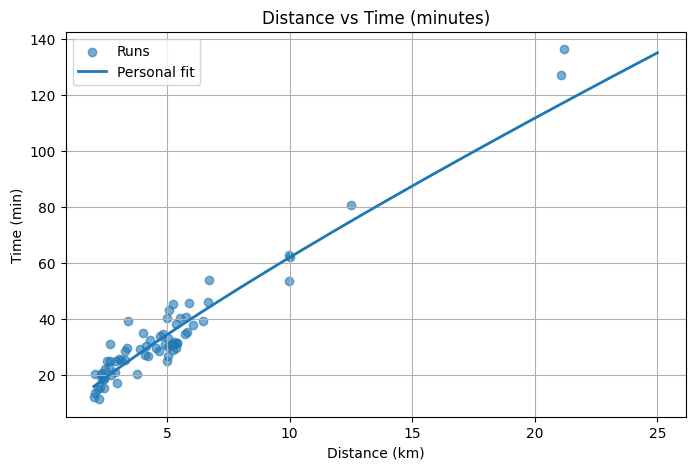

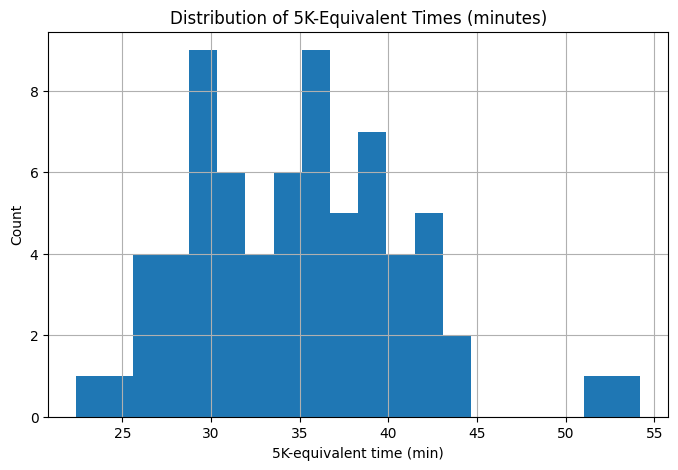

In [68]:
# Distance vs Time (min) with fitted curve
grid = np.linspace(max(2.0, runs["Distance"].min()),
                   min(25.0, max(25.0, runs["Distance"].max())), 200)
curve_min = (c * (grid ** k)) / 60.0

plt.figure()
plt.scatter(runs["Distance"], runs["TimeSec"]/60.0, alpha=0.6, label="Runs")
plt.plot(grid, curve_min, lw=2, label="Personal fit")
plt.title("Distance vs Time (minutes)")
plt.xlabel("Distance (km)")
plt.ylabel("Time (min)")
plt.legend()
plt.show()

# Histogram of per-activity 5K equivalents (minutes)
plt.figure()
plt.hist(T5_each_sec/60.0, bins=20)
plt.title("Distribution of 5K-Equivalent Times (minutes)")
plt.xlabel("5K-equivalent time (min)")
plt.ylabel("Count")
plt.show()


In [69]:
# R² of the log–log fit (over all cleaned runs)
logD = np.log(runs["Distance"].to_numpy())
logT = np.log(runs["TimeSec"].to_numpy())
logT_pred = np.log(c) + k*logD
r2 = r2_score(logT, logT_pred)
print(f"R² (log–log): {r2:.3f}")

# Evaluate on actual ~5Ks (tighter band + exclude very slow 'easy' 5Ks)
band = runs[(runs["Distance"] >= 4.8) & (runs["Distance"] <= 5.2)].copy()
pace_min_per_km = (band["TimeSec"]/60.0) / band["Distance"]
band = band[pace_min_per_km < 9.0]  # drop easy jog 5Ks; adjust threshold as you like

if len(band) >= 3:
    y_true = (band["TimeSec"]/60.0).to_numpy()
    y_pred = np.full_like(y_true, T5_curve_sec/60.0)  # compare to single number
    mae   = mean_absolute_error(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    mape  = float(np.mean(np.abs((y_true - y_pred)/y_true))*100)

    print(f"~5K accuracy (n={len(band)}): MAE={mae:.2f} min, MedAE={medae:.2f} min, MAPE={mape:.1f}%")
else:
    print("Not enough ~5Ks after filtering to compute hold-out metrics (need ≥3).")


R² (log–log): 0.861
~5K accuracy (n=9): MAE=5.00 min, MedAE=4.48 min, MAPE=16.0%


In [70]:
# Only runs with a date column
date_col = None
for ctry in ["Activity Date", "Start Date", "Start Time", "Date"]:
    if ctry in runs.columns:
        date_col = ctry
        break

if date_col is not None:
    rs = runs.copy()
    rs[date_col] = pd.to_datetime(rs[date_col], errors="coerce")
    rs = rs.dropna(subset=[date_col]).sort_values(date_col)
    if len(rs) >= 20:
        cut = int(0.7 * len(rs))  # 70/30 split
        train, test = rs.iloc[:cut].copy(), rs.iloc[cut:].copy()

        k_tr, c_tr, _ = fit_personal_curve(train)
        T5_single_min_tr = (c_tr * (5.0**k_tr)) / 60.0

        band_te = test[(test["Distance"] >= 4.8) & (test["Distance"] <= 5.2)].copy()
        pace_te = (band_te["TimeSec"]/60.0) / band_te["Distance"]
        band_te = band_te[pace_te < 9.0]

        if len(band_te) >= 3:
            y_true = (band_te["TimeSec"]/60.0).to_numpy()
            y_pred = np.full_like(y_true, T5_single_min_tr)
            print("Time-split backtest on recent ~5Ks:")
            print("  MAE:", round(mean_absolute_error(y_true, y_pred), 2), "min")
        else:
            print("Time-split: not enough recent ~5Ks for backtest.")
    else:
        print("Time-split: not enough runs with dates (need ≥20).")
else:
    print("No suitable date column found; skipping time-split backtest.")


Time-split: not enough recent ~5Ks for backtest.


In [71]:
# Focus on your fastest efforts to reflect race ability (top 30% fastest 5K equivalents)
s = pd.Series(T5_each_sec)
fast_slice = s.nsmallest(max(5, int(0.3*len(s))))
print("Personal 5K (fastest 30% median):", fmt_time(float(np.median(fast_slice))))


Personal 5K (fastest 30% median): 29:01


In [72]:
# If you have 'Elevation Gain' and 'Weather Temperature', you can learn how they shift your times.
# Uncomment the HuberRegressor import at the top before running.

if all(col in runs.columns for col in ["Elevation Gain", "Weather Temperature"]):
    # Residual (minutes) vs the curve across all distances
    resid_min = (runs["TimeSec"].to_numpy() - (c * (runs["Distance"].to_numpy()**k))) / 60.0
    Xr = runs[["Elevation Gain", "Weather Temperature"]].copy()
    Xr = Xr.fillna(Xr.median(numeric_only=True))  # simple imputation
    try:
        from sklearn.linear_model import HuberRegressor
        huber = HuberRegressor().fit(Xr, resid_min)
        typical = pd.DataFrame(
            [[Xr["Elevation Gain"].median(), Xr["Weather Temperature"].median()]],
            columns=["Elevation Gain", "Weather Temperature"]
        )
        delta = float(huber.predict(typical)[0])  # minutes
        adjusted_min = (T5_curve_sec/60.0) + delta
        print("Adjusted personal 5K (typical elev/temp):", fmt_time(adjusted_min*60))
        print("Residual model coefficients (min per unit):",
              dict(zip(["Elevation Gain","Weather Temperature"], np.round(huber.coef_, 4))))
    except Exception as e:
        print("Residual correction step skipped due to error:", e)
else:
    print("Residual correction: missing Elevation Gain and/or Weather Temperature.")


Adjusted personal 5K (typical elev/temp): 34:01
Residual model coefficients (min per unit): {'Elevation Gain': np.float64(0.1117), 'Weather Temperature': np.float64(0.3238)}
